In [1]:
%matplotlib inline 

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams.update({'font.size': 18})

from deepmass import map_functions as mf
from deepmass import cnn_keras as cnn

Using TensorFlow backend.


In [2]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.models import load_model

from keras import backend as K
import numpy as np

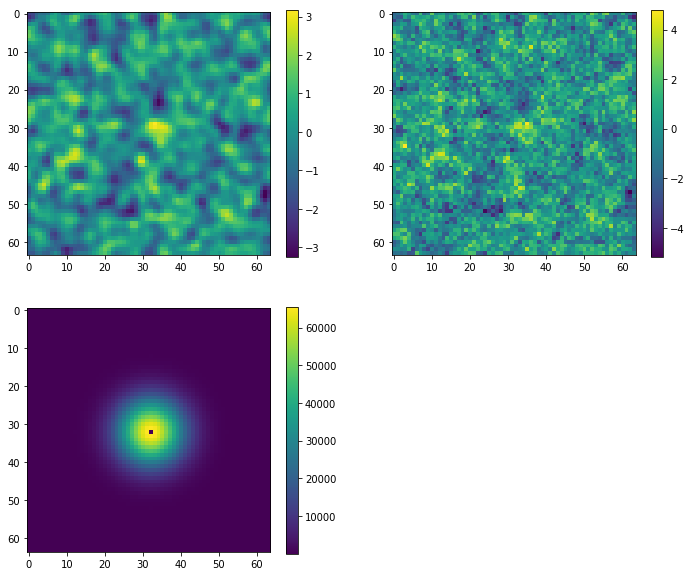

In [3]:
map_size = 64
stdev = 1.
sigma_power = 6.

example, power_map = mf.make_map(map_size, sigma_power)
example = example.real

_ = plt.figure(figsize = (12,10))
_ = plt.subplot(2,2,1), plt.imshow(example), plt.colorbar()
_ = plt.subplot(2,2,2), plt.imshow(example + np.random.normal(0,stdev, (map_size,map_size,))), plt.colorbar()
_ = plt.subplot(2,2,3), plt.imshow(power_map), plt.colorbar()



In [4]:
counts = np.load('misc_data/sv_sim_counts.npy')[0].T

counts_shaped =  counts.reshape(map_size, int(counts.shape[0]/map_size),
                                map_size, int(counts.shape[1]/map_size)).sum(axis=1).sum(axis=2)
mask = np.where(counts_shaped>0.0, 1.0, 0.0)
mask = np.float32(mask.real)

# comment out if mask needed
mask = np.ones(mask.shape)

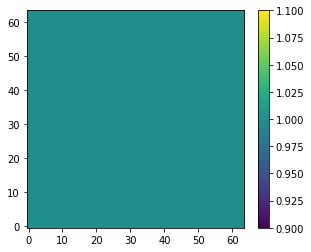

In [5]:
_ = plt.imshow(mask, origin = 'lower'), plt.colorbar(fraction=0.046, pad=0.04)

In [6]:
# training_size = 40000
# testing_size = 1000

# train_array_clean = np.empty((training_size,map_size,map_size,1), dtype = np.float32)
# train_array_noisy = np.empty((training_size,map_size,map_size,1), dtype = np.float32)
# test_array_clean = np.empty((testing_size,map_size,map_size,1), dtype = np.float32)
# test_array_noisy = np.empty((testing_size,map_size,map_size,1), dtype = np.float32)
# print(train_array_clean.shape)

# for i in range(training_size):
#     image, foo = mf.make_map(map_size, sigma_power)
#     image = np.float32(np.real(image))
#     image += -np.mean(image)
#     train_array_clean[i,:,:,0] = np.real(image)
#     train_array_noisy[i,:,:,0] = np.real(image) + np.float32(np.random.normal(0,stdev, (map_size,map_size,)))
#     train_array_noisy[i,:,:,0] = train_array_noisy[i,:,:,0] * mask

    
# for i in range(testing_size):
#     image, foo = mf.make_map(map_size, sigma_power)
#     image = np.float32(np.real(image))
#     image += -np.mean(image)
#     test_array_clean[i,:,:,0] = np.real(image)
#     test_array_noisy[i,:,:,0] = np.real(image) + np.float32(np.random.normal(0,stdev, (map_size,map_size,)))
#     test_array_noisy[i,:,:,0] = test_array_noisy[i,:,:,0] * mask
    
# np.save('misc_data/train_clean_64_10000', train_array_clean)
# np.save('misc_data/train_noisy_64_10000', train_array_noisy)
# np.save('misc_data/test_clean_64_10000', test_array_clean)
# np.save('misc_data/test_noisy_64_10000', test_array_noisy)


(40000, 64, 64, 1)


In [7]:
train_array_clean = np.load('misc_data/train_clean_64_10000.npy')
train_array_noisy = np.load('misc_data/train_noisy_64_10000.npy')
test_array_clean = np.load('misc_data/test_clean_64_10000.npy')
test_array_noisy = np.load('misc_data/test_noisy_64_10000.npy')

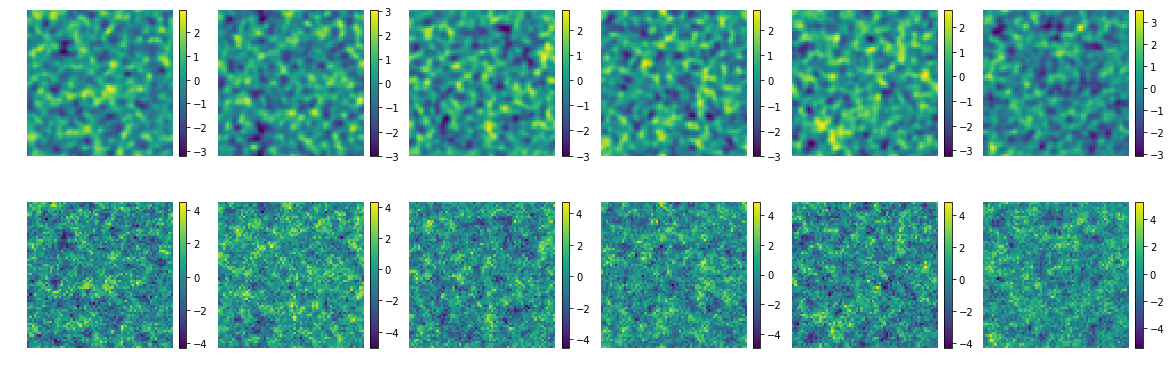

In [12]:
n = 6  # how many images displayed

plt.figure(figsize=(20, 10))
for i in range(n):
    # display original
    plt.subplot(3, n, i + 1)
    plt.imshow(train_array_clean[i,:,:,0], origin = 'lower')#, clim= (0.,1.))
    plt.axis('off'), plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.subplot(3, n, i + 1 + n)
    plt.imshow(train_array_noisy[i,:,:,0], origin = 'lower')#, clim= (0.,1.))
    plt.axis('off'), plt.colorbar(fraction=0.046, pad=0.04)
    
plt.show()

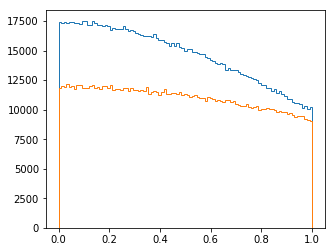

In [9]:
_  = plt.figure(figsize = (5,4))
_ = plt.hist(np.reshape(test_array_clean, -1), np.linspace(-5,5,100), histtype = 'step')
_ = plt.hist(np.reshape(test_array_noisy, -1), np.linspace(-5,5,100), histtype = 'step')

In [10]:
autoencoder_instance = cnn.autoencoder_model(map_size = 64)
autoencoder = autoencoder_instance.model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 32)        0         
__________

In [11]:
autoencoder.fit(train_array_noisy, train_array_clean,
                epochs=10,
                batch_size=100,
                shuffle=True,
                validation_data=(test_array_noisy, test_array_clean),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 40000 samples, validate on 1000 samples
Epoch 1/10
36500/40000 [==========================>...] - ETA: 1:11 - loss: 0.6429

KeyboardInterrupt: 

In [ ]:
test_output = autoencoder.predict(test_array_noisy)

n = 6  # how many images displayed

plt.figure(figsize=(30, 15))
for i in range(n):
    # display original
    plt.subplot(3, n, i + 1)
    plt.imshow(test_array_clean[i,:,:,0], origin = 'lower')#, clim= (0.,1.))
    plt.axis('off'), plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.subplot(3, n, i + 1 + n)
    plt.imshow(test_array_noisy[i,:,:,0], origin = 'lower')#, clim= (0.,1.))
    plt.axis('off'), plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(test_output[i,:,:,0], origin = 'lower')#, clim= (0.,1.))
    plt.axis('off'), plt.colorbar(fraction=0.046, pad=0.04)

    plt.axis('off')
plt.show()

In [ ]:
Sft_diagonal = np.reshape(power_map, -1)
N_constant_diagonal = np.ones(Sft_diagonal.shape) * stdev * stdev
Nft_constant_diagonal = N_constant_diagonal * 64 * 64.


W = Sft_diagonal / (Sft_diagonal + Nft_constant_diagonal)

In [ ]:
fourier_data = np.fft.fftshift(np.fft.fft2(test_array_noisy[0,:,:,0]-0.5))

In [ ]:
wiener_map_fourier = np.reshape( W* np.reshape(fourier_data, -1), (64,64))
wiener_map = np.fft.ifft2(np.fft.fftshift(wiener_map_fourier))

In [ ]:
plt.figure(figsize = (10,8))
plt.subplot(2,2,1)
plt.imshow(test_output[0,:,:,0].real - 0.5, clim = (-0.12,0.12)), plt.title('cnn'), plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(test_array_clean[0,:,:,0].real - 0.5, clim = (-0.12,0.12)), plt.title('truth'), plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(wiener_map.real, clim = (-0.12,0.12)), plt.title('wiener'), plt.colorbar()

In [ ]:
autoencoder.save('encoder_301018.h5')

In [ ]:
read_encoder = load_model('encoder_301018.h5')

In [ ]:
test_output_loaded = read_encoder.predict(test_array_noisy)

n = 6  # how many images displayed

plt.figure(figsize=(30, 15))
for i in range(n):
    # display original
    plt.subplot(3, n, i + 1)
    plt.imshow(test_array_clean[i,:,:,0], origin = 'lower')#, clim= (0.,1.))
    plt.axis('off')
    
    plt.subplot(3, n, i + 1 + n)
    plt.imshow(test_array_noisy[i,:,:,0], origin = 'lower')#, clim= (0.,1.))
    plt.axis('off')
    
    plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(test_output_loaded[i,:,:,0], origin = 'lower')#, clim= (0.,1.))
    plt.axis('off')

    plt.axis('off')
plt.show()

In [ ]:
from keras.utils import plot_model
plot_model(read_encoder, show_shapes=True, show_layer_names=False, to_file='model.png')

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(read_encoder, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))